In [ ]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("DDICorpus2013.csv")

In [ ]:
df = df.drop_duplicates()

# Function to standardize drug names: lowercase and remove special characters
def clean_drug_name(name):
    if pd.isna(name):
        return "unknown"
    name = name.lower()
    name = re.sub(r'[^a-z0-9 ]', '', name)
    return name

In [ ]:
df['Drug_1_Name'] = df['Drug_1_Name'].apply(clean_drug_name)
df['Drug_2_Name'] = df['Drug_2_Name'].apply(clean_drug_name)

# Fill missing values for drug names and the interaction flag
df['Drug_1_Name'] = df['Drug_1_Name'].fillna("unknown")
df['Drug_2_Name'] = df['Drug_2_Name'].fillna("unknown")
df['Is_DDI'] = df['Is_DDI'].fillna(0)

In [ ]:
all_drugs = list(set(df['Drug_1_Name']).union(set(df['Drug_2_Name'])))
num_positive = df[df['Is_DDI'] == 1].shape[0]
synthetic_samples = []
np.random.seed(42)
while len(synthetic_samples) < num_positive:
    d1, d2 = np.random.choice(all_drugs, 2, replace=False)
    exists = ((df['Drug_1_Name'] == d1) & (df['Drug_2_Name'] == d2)).any() or \
             ((df['Drug_1_Name'] == d2) & (df['Drug_2_Name'] == d1)).any()
    if not exists:
        synthetic_samples.append({
            'Drug_1_Name': d1,
            'Drug_2_Name': d2,
            'Is DDI': 0,
            'Sentence_Text': ""  # no known interaction text
        })
synthetic_df = pd.DataFrame(synthetic_samples)
df = pd.concat([df, synthetic_df], ignore_index=True)

In [ ]:
df['Sentence_Text'] = df['Sentence_Text'].fillna('')
tfidf = TfidfVectorizer(max_features=2000)  # limit features for demonstration
X_tfidf = tfidf.fit_transform(df["Sentence_Text"])

# Optional: Dimensionality reduction to keep the embedding small
svd = TruncatedSVD(n_components=200, random_state=42)  # pick dimension that suits your data
X_tfidf_reduced = svd.fit_transform(X_tfidf)  # shape: [num_edges, 200]

# Convert to torch tensor for usage in the model
edge_text_features = torch.tensor(X_tfidf_reduced, dtype=torch.float)

# ----------------------------
# 4. Graph Construction
# ----------------------------
drugs = list(set(df['Drug_1_Name']).union(set(df['Drug_2_Name'])))
drug_to_idx = {drug: idx for idx, drug in enumerate(drugs)}
num_nodes = len(drug_to_idx)

# For demonstration, we still use identity node features.
node_features = torch.eye(num_nodes)

edge_list = []
edge_labels = []
for i, row in df.iterrows():
    src = drug_to_idx[row['Drug_1_Name']]
    dst = drug_to_idx[row['Drug_2_Name']]
    edge_list.append([src, dst])
    # Change to handle NaN values before converting to integer:
    edge_labels.append(int(row['Is_DDI']) if not pd.isna(row['Is_DDI']) else 0)

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_labels = torch.tensor(edge_labels, dtype=torch.float)

In [ ]:
data = Data(
    x=node_features,
    edge_index=edge_index,
    y=edge_labels
)
# We'll store the text features separately in the Data object
# so we can access them easily in the forward pass.
data.edge_text_features = edge_text_features

# ----------------------------
# 5. Split Edges into Train/Val/Test
# ----------------------------
edge_indices = np.arange(edge_index.size(1))
train_idx, temp_idx = train_test_split(
    edge_indices, test_size=0.3, stratify=edge_labels.numpy(), random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=edge_labels.numpy()[temp_idx], random_state=42
)

train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

In [ ]:
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

# UPDATED Edge Classifier to include text embeddings
class EdgeClassifierWithText(nn.Module):
    def __init__(self, node_emb_dim, text_emb_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(node_emb_dim*2 + text_emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, emb, edge_index, edge_text_emb, edge_idx):
        """
        emb: [num_nodes, node_emb_dim] - GAT node embeddings
        edge_index: [2, num_edges] - global edge index
        edge_text_emb: [num_edges, text_emb_dim] - TF-IDF text features
        edge_idx: [batch_size] - indices of edges we want to classify (train, val, or test subset)
        """
        # Get the relevant edges
        src = edge_index[0, edge_idx]
        dst = edge_index[1, edge_idx]

        # Node embeddings for each edge in the batch
        src_emb = emb[src]
        dst_emb = emb[dst]

        # Text embeddings for each edge in the batch
        text_emb = edge_text_emb[edge_idx]  # shape: [batch_size, text_emb_dim]

        # Concatenate node embeddings + text embeddings
        edge_feat = torch.cat([src_emb, dst_emb, text_emb], dim=1)  # shape: [batch_size, node_emb_dim*2 + text_emb_dim]

        x = F.relu(self.fc1(edge_feat))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

# Initialize
node_emb_dim = num_nodes  # we used identity matrix => num_nodes
text_emb_dim = data.edge_text_features.shape[1]
hidden_channels = 64
out_channels = 64

gat_model = GATNet(in_channels=node_emb_dim, hidden_channels=hidden_channels, out_channels=out_channels)
edge_classifier = EdgeClassifierWithText(node_emb_dim=out_channels, text_emb_dim=text_emb_dim, hidden_dim=64)

criterion = nn.BCELoss()
optimizer = optim.Adam(list(gat_model.parameters()) + list(edge_classifier.parameters()), lr=0.001)


In [ ]:
num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    gat_model.train()
    edge_classifier.train()
    optimizer.zero_grad()

    # Compute node embeddings for the entire graph
    embeddings = gat_model(data.x, data.edge_index)

    # Training edges and labels
    train_labels = data.y[train_idx]

    # Forward pass: now we include text features
    train_preds = edge_classifier(
        emb=embeddings,
        edge_index=data.edge_index,
        edge_text_emb=data.edge_text_features,
        edge_idx=train_idx
    )
    loss = criterion(train_preds, train_labels)
    loss.backward()
    optimizer.step()

    # Validation
    gat_model.eval()
    edge_classifier.eval()
    with torch.no_grad():
        embeddings_val = gat_model(data.x, data.edge_index)
        val_labels = data.y[val_idx]
        val_preds = edge_classifier(
            emb=embeddings_val,
            edge_index=data.edge_index,
            edge_text_emb=data.edge_text_features,
            edge_idx=val_idx
        )
        val_loss = criterion(val_preds, val_labels)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_gat_state = gat_model.state_dict()
        best_edge_state = edge_classifier.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/100, Loss: 0.6952, Val Loss: 0.6938
Epoch 2/100, Loss: 0.6938, Val Loss: 0.6924
Epoch 3/100, Loss: 0.6923, Val Loss: 0.6910
Epoch 4/100, Loss: 0.6908, Val Loss: 0.6893
Epoch 5/100, Loss: 0.6889, Val Loss: 0.6879
Epoch 6/100, Loss: 0.6873, Val Loss: 0.6864
Epoch 7/100, Loss: 0.6858, Val Loss: 0.6848
Epoch 8/100, Loss: 0.6840, Val Loss: 0.6831
Epoch 9/100, Loss: 0.6819, Val Loss: 0.6811
Epoch 10/100, Loss: 0.6798, Val Loss: 0.6788
Epoch 11/100, Loss: 0.6767, Val Loss: 0.6763
Epoch 12/100, Loss: 0.6739, Val Loss: 0.6734
Epoch 13/100, Loss: 0.6704, Val Loss: 0.6703
Epoch 14/100, Loss: 0.6665, Val Loss: 0.6669
Epoch 15/100, Loss: 0.6621, Val Loss: 0.6628
Epoch 16/100, Loss: 0.6573, Val Loss: 0.6581
Epoch 17/100, Loss: 0.6515, Val Loss: 0.6527
Epoch 18/100, Loss: 0.6444, Val Loss: 0.6468
Epoch 19/100, Loss: 0.6379, Val Loss: 0.6404
Epoch 20/100, Loss: 0.6306, Val Loss: 0.6335
Epoch 21/100, Loss: 0.6228, Val Loss: 0.6261
Epoch 22/100, Loss: 0.6137, Val Loss: 0.6182
Epoch 23/100, Loss:


--- Test Set Performance ---
Test Loss: 0.5222508907318115
Accuracy: 0.7628247834776816
Precision: 0.7612732095490716
Recall: 0.7653333333333333
F1 Score: 0.7632978723404256
ROC-AUC: 0.8316076342654238


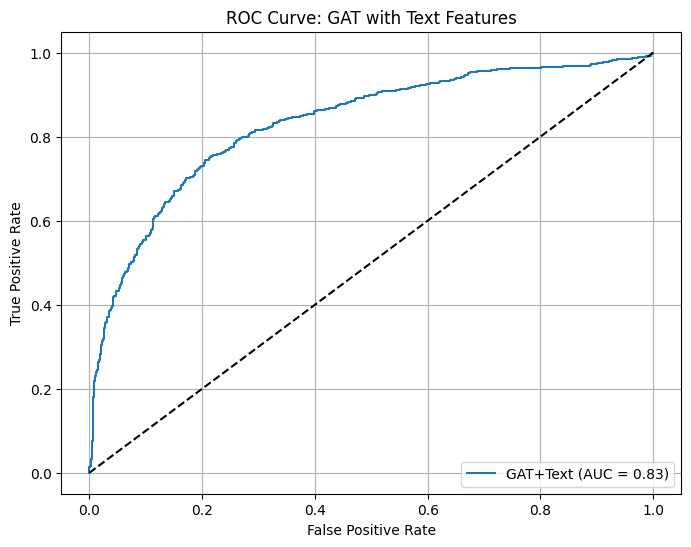

In [ ]:
gat_model.load_state_dict(best_gat_state)
edge_classifier.load_state_dict(best_edge_state)

# ----------------------------
# 8. Evaluation on Test Set
# ----------------------------
gat_model.eval()
edge_classifier.eval()
with torch.no_grad():
    embeddings_test = gat_model(data.x, data.edge_index)
    test_labels = data.y[test_idx]
    test_preds = edge_classifier(
        emb=embeddings_test,
        edge_index=data.edge_index,
        edge_text_emb=data.edge_text_features,
        edge_idx=test_idx
    )
    pred_labels = (test_preds > 0.5).float()

    test_loss = criterion(test_preds, test_labels).item()
    test_acc = accuracy_score(test_labels.cpu().numpy(), pred_labels.cpu().numpy())
    test_precision = precision_score(test_labels.cpu().numpy(), pred_labels.cpu().numpy())
    test_recall = recall_score(test_labels.cpu().numpy(), pred_labels.cpu().numpy())
    test_f1 = f1_score(test_labels.cpu().numpy(), pred_labels.cpu().numpy())
    roc_auc = roc_auc_score(test_labels.cpu().numpy(), test_preds.cpu().numpy())

    print("\n--- Test Set Performance ---")
    print("Test Loss:", test_loss)
    print("Accuracy:", test_acc)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("F1 Score:", test_f1)
    print("ROC-AUC:", roc_auc)

# Plot ROC
fpr, tpr, _ = roc_curve(test_labels.cpu().numpy(), test_preds.cpu().numpy())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"GAT+Text (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: GAT with Text Features")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
def clean_drug_name_for_inference(name):
    return re.sub(r'[^a-z0-9 ]', '', name.lower())

def predict_interaction(drug_list, threshold=0.5):
    """
    Takes a list of drug names and returns text describing the predicted interaction
    for each pair, leveraging both node embeddings and TF-IDF text features.
    Note: Because the text features live on edges in this model,
    you need 'Sentence Text' for each potential pair or you do a fallback if unknown.
    """
    gat_model.eval()
    edge_classifier.eval()

    # Clean input drug names
    drugs_input = [clean_drug_name_for_inference(d) for d in drug_list]
    missing = [d for d in drugs_input if d not in drug_to_idx]
    if missing:
        return [f"Error: The following drugs are not found in the database: {', '.join(missing)}"]

    # For each pair, we find the edge if it exists in the dataset
    # If not in the dataset, we can either say "No known data" or create a synthetic edge with no text.
    embeddings = gat_model(data.x, data.edge_index)
    outputs = []

    # We'll do pairwise combinations
    from itertools import combinations
    for d1, d2 in combinations(drugs_input, 2):
        idx1 = drug_to_idx[d1]
        idx2 = drug_to_idx[d2]

        # Find the index of the row in the original dataset if it exists
        # (i.e., if the user wants the original text-based feature)
        # For demonstration, we do a simple check:
        # We'll see if there's an exact match in df
        pair_idx = df.index[
            ((df['Drug_1_Name'] == d1) & (df['Drug_2_Name'] == d2)) |
            ((df['Drug_1_Name'] == d2) & (df['Drug_2_Name'] == d1))
        ]

        if len(pair_idx) == 0:
            # If the pair doesn't exist, we can't rely on the trained edge features
            # We'll default to "No known data"
            outputs.append(f"No known data for '{d1}' and '{d2}'.")
        else:
            # For simplicity, just pick the first match if there are duplicates
            e_idx = pair_idx[0]

            # Convert that row index to the corresponding edge index in the model
            # Because e_idx in df aligns with the row we built in 'edge_text_features'
            # We'll create a single-element tensor for forward pass
            e_idx_tensor = torch.tensor([e_idx], dtype=torch.long)

            # Predict
            pred_prob = edge_classifier(
                emb=embeddings,
                edge_index=data.edge_index,
                edge_text_emb=data.edge_text_features,
                edge_idx=e_idx_tensor
            ).item()

            if pred_prob >= threshold:
                text = (f"Potential interaction detected between '{d1}' and '{d2}' "
                        f"(Probability: {pred_prob:.2f}).")
            else:
                text = (f"No significant interaction predicted between '{d1}' and '{d2}' "
                        f"(Probability: {pred_prob:.2f}).")
            outputs.append(text)
    return outputs

# Example usage:
results = predict_interaction(["asparaginase", "proleukin"])
for r in results:
    print(r)

Potential interaction detected between 'asparaginase' and 'proleukin' (Probability: 0.75).
